<a href="https://colab.research.google.com/github/thissop/MAXI-J1535/blob/main/code/machine-learning/December-%202021-2022/grid_search_and_testing_fourth_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# grid search and testing fourth class 

## Notes

* It seems that the default sklearn split quality criterion is squared error, which is the same thing as MSE. Thus, I should report values in terms of MSE // scaled MSE?

    * probably use/report the $R^2$ values instead...seems like the sklearn regr.score() is different than OLS $R^2$ for random forest? See this [link](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.score)

* Potentially similiar paper in Bio: [link](https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-021-01688-3)

* what are the current spectral channels included?

* to validate the claim about how it's potentially interesting that the RF on counts data 

## testing fourth class

In [6]:
!pip install rebin
!pip install shap
import shap
import graphviz
from rebin import rebin 
import pandas as pd
import sklearn
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale as normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error as mse_score
from sklearn.metrics import median_absolute_error as mae_score
from sklearn.metrics import accuracy_score as acc_score
from sklearn.metrics import r2_score 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.multioutput import RegressorChain
from sklearn import utils 
from sklearn.model_selection import KFold, StratifiedKFold

plt.style.use('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/code/misc/stolen_science.mplstyle?token=GHSAT0AAAAAABP54PQO2X2VXMNS256IWOBOYRNCFBA')

rs = 4

     |████████████████████████████████| 564 kB 5.0 MB/s 


In [7]:
# methods

def norm(x, min, max): 
    return (x - min) / (max - min)

def unnorm(x_, min, max):
    return x_*(max-min)+min

In [32]:
### FOR SPECTRAL INFORMATION!!

spectral_df = pd.read_csv('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/code/misc/count_rates_initial_exploration/count_rates_transposed.csv')
qpo_df = pd.read_csv('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/data/processed/2022/new_current_qpos.csv').fillna(0)

spectral_df.sort_values(by='full_id')
qpo_df.sort_values(by='full_id')

mask = np.where(np.isfinite(qpo_df['num_qpos']))

qpo_df = qpo_df.iloc[mask]

spectral_indices = []
for i in qpo_df['full_id']: 
    spectral_indices.append(np.where(spectral_df['full_id']==i)[0][0])

spectral_df = spectral_df.iloc[spectral_indices]

for i in ['first_freq', 'second_freq', 'first_width', 'second_width', 'first_norm', 'second_norm']: 
    qpo_df = qpo_df.astype({i:float})

for i, j in zip(qpo_df['full_id'], spectral_df['full_id']): 
    if i!=j: 
        print('mis-match')
        print(i,j)

full_ids = np.array(qpo_df['full_id'])

In [53]:
all_confidences = np.array(qpo_df['confidence_class'])
train_mask = np.logical_and(all_confidences<3, all_confidences>-1)
non_zero_mask = np.logical_and(qpo_df['num_qpos']>0, train_mask)
test_mask = np.logical_or(all_confidences==3, all_confidences==4)
third_mask = np.where(all_confidences==3)
fourth_mask = np.where(all_confidences==4)

In [56]:
# package x values

bins = 25

x = []

for i in range(len(spectral_df.index)): 
    counts_row = np.array(spectral_df.iloc[[i]])[0][1:].astype(float) 
    
    rebin_factor = int(np.floor(len(counts_row)/bins))
    
    rebined = rebin(counts_row, rebin_factor)
    x.append(rebined)

x = np.array(x)

# package y values

combined_freqs = np.concatenate((qpo_df['first_freq'], qpo_df['second_freq']))
min_freq, max_freq = (np.min(combined_freqs), np.max(combined_freqs))
combined_widths = np.concatenate((qpo_df['first_width'], qpo_df['second_width']))
min_width, max_width = (np.min(combined_widths), np.max(combined_widths))
combined_norms = np.concatenate((qpo_df['first_norm'], qpo_df['second_norm']))
min_norm, max_norm = (np.min(combined_norms), np.max(combined_norms))

y_col_names = ['first_freq', 'second_freq', 'third_freq']
freq1s, freq2s, freq3s = (norm(np.array(qpo_df[arr_name]), min_freq, max_freq) for arr_name in y_col_names)

freqs = np.array([], dtype=float).reshape(0,2)
widths = np.array([], dtype=float).reshape(0,2)
norms = np.array([], dtype=float).reshape(0,2)

y_vals = []

for i in range(len(freq1s)): 
    row_matrix = np.array([freq1s[i], freq2s[i], freq3s[i]])
    y_vals.append(row_matrix)

y_vals = np.array(y_vals)

x_vals = x

X_train = x[train_mask]
y_train = y_vals[train_mask]

X_train_no_zero = x[non_zero_mask]
y_train_no_zero = y_vals[non_zero_mask]

[Text(0, 0.5, 'Predicted Frequency'), Text(0.5, 0, 'True Frequency')]

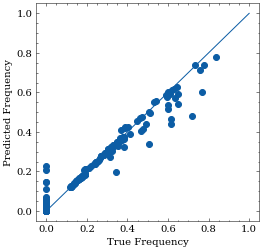

In [46]:
regr = RandomForestRegressor()
regr.fit(X_train,y_train)

regr.score(X_train, y_train)

fig, ax = plt.subplots(figsize=(4,4))

predictions = regr.predict(X_train)

ax.scatter(y_train, predictions)
ax.plot((0,1), (0,1))

ax.set(xlabel='True Frequency', ylabel='Predicted Frequency')

ValueError: ignored

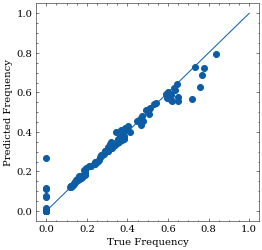

In [71]:
from pandas.compat.numpy.function import RESHAPE_DEFAULTS
regr = RandomForestRegressor()
regr.fit(X_train_no_zero,y_train_no_zero)

regr.score(X_train_no_zero, y_train_no_zero)

fig, ax = plt.subplots(figsize=(4,4))

predictions = regr.predict(X_train_no_zero)

ax.scatter(y_train_no_zero, predictions)
ax.plot((0,1), (0,1))

ax.set(xlabel='True Frequency', ylabel='Predicted Frequency')

reshaped_predictions = np.transpose(predictions)
reshaped_true = np.transpose(y_train)

for i in range(2): 
    diffs = (reshaped_predictions[i]-reshaped_true[i])**2
    print(full_ids[non_zero_mask][np.argsort(diffs)[::-1]][0:10])

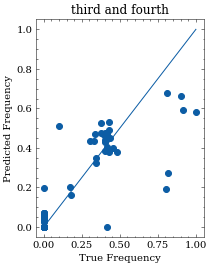

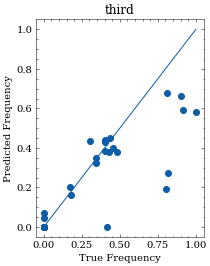

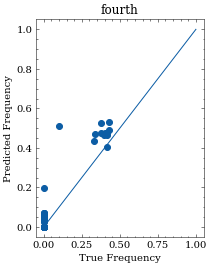

In [60]:
## all third and fourth
for mask, label in zip([test_mask, third_mask, fourth_mask], ['third and fourth', 'third', 'fourth']):
    y_test = y_vals[mask]
    x_test = x_vals[mask]

    fig, ax = plt.subplots(figsize=(3,4))

    score = regr.score(x_test, y_test)
    ax.scatter(y_test, regr.predict(x_test), label='Score: '+f'{score:.2f}')
    ax.plot((0,1), (0,1))

    ax.set(xlabel='True Frequency', ylabel='Predicted Frequency', title=label)

    plt.show()
    plt.clf()
    plt.close()

### Grid Search

In [5]:
from sklearn.metrics import mean_squared_error as mse_score
from sklearn.metrics import median_absolute_error as mae_score
from sklearn.metrics import accuracy_score as acc_score
from sklearn.metrics import r2_score 
from sklearn.ensemble import RandomForestRegressor
def run_grid_search(grid, X, y, n_splits: int = 10, model: str = 'randomforest'): 
    import numpy as np
    from sklearn.model_selection import StratifiedKFold
    from sklearn.linear_model import LinearRegression
    from sklearn.ensemble import RandomForestRegressor
    
    skf = StratifiedKFold(n_splits=n_splits)

    if model=='randomforest': 

        grid_dict = {'n_estimators':[50, 100, 500, 1000],
                'min_samples_split':[2,4,6,8],
                'min_samples_leaf':[1,2,3]}

        keys = grid_dict.keys()
        grid_matrix = []
        grid_scores = []
        for i in grid_dict[keys[0]]: 
            for j in grid_dict[keys[1]]: 
                for k in grid_dict[keys[2]]: 
                    combination = [i,j,k]
                    grid_matrix.append(combination)

        for combination in grid_matrix: 
            scores = []
            for train_index, test_index in skf.split(X, y):

                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                regr = RandomForestRegressor(n_estimators=combination[0], 
                                             min_samples_split=combination[1], 
                                             min_samples_leaf=combination[2])
                regr.fit(X_train,y_train)

                predictions = regr.predict(X_test)
                
                score = regr.score(y_test, predictions)
                scores.append(score)
            
            grid_scores.append(np.mean(scores))
    
        return grid_matrix, grid_scores

    elif model=='linear':
        scores = []
        for train_index, test_index in skf.split(X, y):

            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            regr = LinearRegression()
            regr.fit(X_train,y_train)

            predictions = regr.predict(X_test)
            
            score = regr.score(y_test, predictions)
            scores.append(score)

        return scores, np.mean(scores)